In [1]:
import numpy as np
import pandas as pd
import torch
import random
import tqdm
from tqdm.contrib.telegram import tqdm, trange
from transformers import AutoTokenizer, AutoModel, BertForMaskedLM, RobertaForMaskedLM
import pickle
from bs4 import BeautifulSoup
import warnings
import torch.optim as optim
import time
import math
import sys
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from sklearn.metrics import (
    roc_auc_score, accuracy_score, roc_curve,
    average_precision_score, precision_recall_curve
)
from torch.utils.data import Dataset, DataLoader, Sampler, random_split
from transformers import get_linear_schedule_with_warmup, get_constant_schedule
import os
from os import listdir
from os.path import isfile, join
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
from tqdm.notebook import tqdm
tqdm.pandas()
warnings.filterwarnings('ignore')

# Masked language modeling for pre-train Bert

In [2]:
torch.cuda.manual_seed(123)
np.random.seed(123)
random.seed(123)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

## Importing the dataset

In [3]:
with open('/home/jovyan/sentences.pkl', 'rb') as f:
    sentences = pickle.load(f)  
len(sentences)    

27309035

In [4]:
split = 25000000
sentences, test_sentences = sentences[:split], sentences[split:]
len(sentences), len(test_sentences)    

(25000000, 2309035)

## Preparing the dataset

In [5]:
# model_name = "sberbank-ai/ruRoberta-large"
model_name = "sberbank-ai/ruBert-large"
# model_name = 'sberbank-ai/ruBert-base'

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [8]:
class DescriptionDataset(Dataset):
    def __init__(self, tokenizer, descs, max_len=128):
        self.descs = descs
        self.max_len = max_len
        self.tokenizer = tokenizer
        
        
    def __getitem__(self, idx):
        
        desc_cls = '[CLS]' + self.descs[idx]       
        tokenized_desc_cls = self.get_tokens(desc_cls, max_len=self.max_len)
        cat_ids = tokenized_desc_cls['input_ids']
        cat_atts = tokenized_desc_cls['attention_mask']                
        
        labels = cat_ids.detach().clone()
        
        tokenized_descs = {
            "input_ids": self.get_masked(cat_ids),
            "attention_mask": cat_atts,
            "labels": labels
        }
        
        return tokenized_descs

    def __len__(self):
        return len(self.descs)
    
    def get_tokens(self, row, max_len=128, pad_str='max_length'):
        tokenized = self.tokenizer.encode_plus(
            row, add_special_tokens=False, truncation=True,
            max_length=max_len, padding=pad_str, 
            return_tensors='pt', return_token_type_ids=False
        )
        return tokenized
    
    def get_masked(self, input_ids):
        rand = torch.rand(input_ids.shape)
        mask_arr = (rand < 0.15) * (input_ids != 101) * \
                   (input_ids != 102) * (input_ids != 0)
        
        input_ids[mask_arr] = 103
            
        return input_ids

In [9]:
train_data = DescriptionDataset(
    tokenizer,
    sentences
)

val_data = DescriptionDataset(
    tokenizer,
    test_sentences
)

BATCH_SIZE = 128

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

## Choosing model to MLM train

In [10]:
import torch.nn as nn
from IPython.display import clear_output
device = 'cuda'
if model_name == "sberbank-ai/ruRoberta-large":    
    model = RobertaForMaskedLM.from_pretrained(model_name)
elif model_name == "sberbank-ai/ruRoberta-large":
    model = BertForMaskedLM.from_pretrained(model_name)
elif model_name == 'sberbank-ai/ruBert-base':
    model = BertForMaskedLM.from_pretrained(model_name)    
    
model.resize_token_embeddings(len(tokenizer))
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    print('more than one GPU')

Some weights of the model checkpoint at sberbank-ai/ruBert-base were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
model.train()
model.to(device)
clear_output(False)

## Sending logs to telegram during training

In [12]:
def telegram_bot_sendtext(bot_message):

    bot_token = 'bot_token'
    bot_chatID = 'bot_chatID'
    send_text = 'https://api.telegram.org/bot' + bot_token + '/sendMessage?chat_id=' + bot_chatID + '&parse_mode=Markdown&text=' + bot_message

    response = requests.get(send_text)

    return response.json()

## Code Train and Evaluate

In [13]:
from torch.cuda.amp import GradScaler
use_amp = True
# scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

def train(model, iterator, optimizer, scheduler,
    train_history=None, valid_history=None
    ):
    
    epoch_loss = 0
    history = []
    
    model.train()
    scaler = GradScaler()
    
    optimizer.zero_grad()
    telegram_bot_sendtext(f'start training!')   
    for i, batch in enumerate(iterator):
        tokens = batch['input_ids'].squeeze(1).to(device)
        att = batch['attention_mask'].squeeze(1).to(device)
        
        labels = batch['labels'].squeeze(1).to(device)
        
        
        with torch.cuda.amp.autocast(enabled=use_amp):                    
            loss = model(tokens, att, labels=labels).loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()            
        
        scheduler.step()
        
        epoch_loss += loss.cpu().data.numpy()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%1000==0:
            torch.save(model.state_dict(), f'model_mlm_ruBert_base.pt')
            telegram_bot_sendtext(f'Batch {i}/{len(iterator)}')
            telegram_bot_sendtext(f'loss {loss}')  
            
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

    return epoch_loss / (i + 1)

def evaluate(model, iterator):
    print('start_eval')
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
        for i, batch in tqdm(enumerate(iterator), total=len(iterator)):
            tokens_article = batch['input_ids'].squeeze(1).to(device)
            att_article = batch['attention_mask'].squeeze(1).to(device)

            labels = batch['labels'].squeeze(1).to(device)

            output = model(tokens_article, att_article, labels=labels)

            loss = output.loss.sum().detach().cpu()
            
            epoch_loss += loss.item()
        
    return epoch_loss / (i + 1)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Start MLM trainig

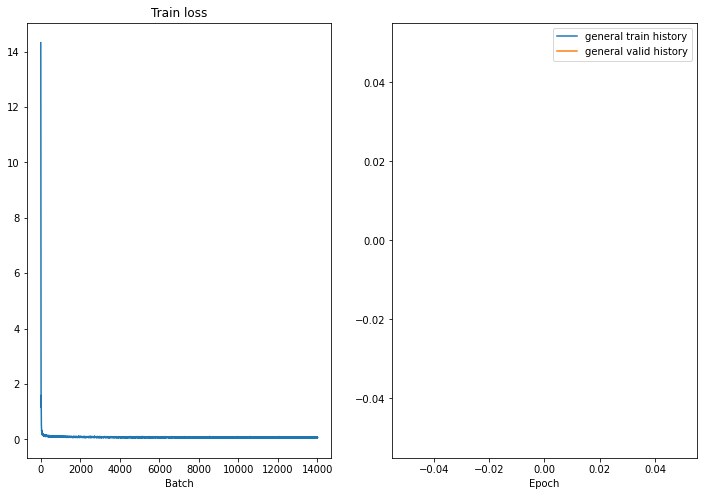

In [ ]:
train_history = []
valid_history = []

optimizer = optim.AdamW(model.parameters(), lr=1e-5)

N_EPOCHS = 1
CLIP = 1

best_valid_loss = 10

total_steps = len(train_loader) * N_EPOCHS
scheduler = get_constant_schedule(optimizer)

for epoch in range(N_EPOCHS):    
    
    start_time = time.time()
    
    train_loss = train(
        model, train_loader, optimizer, scheduler,
        train_history, valid_history
        )

    valid_loss = evaluate(model, val_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    train_loss = train_loss.sum()
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    telegram_bot_sendtext(f'{epoch} epoch done')   
    


In [ ]:
telegram_bot_sendtext(f'DONE MTFC!')      